In [1]:
import contextlib

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.datasets.multi_build import build_dataset_from_keys
from src.models.segformer_baseline import load_model
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

In [2]:
BUILD_KEYS = ["tcr_phase1_build1", "tcr_phase1_build2"]

### 1. Dataset & DataLoader

Just 10 layers for now

In [3]:
# Build & split
full_ds = build_dataset_from_keys(
    # BUILD_KEYS, size=512, augment=True, layers=range(0, 100, 10)
    BUILD_KEYS, size=512, augment=True, layers=None
)
n_val   = int(len(full_ds)*0.1)
n_train = len(full_ds) - n_val
train_ds, val_ds = random_split(full_ds, 
								[n_train,n_val], 
								generator=torch.Generator().manual_seed(42))

print("dataset sizes:", len(train_ds), len(val_ds))

dataset sizes: 6423 713


In [4]:
#  Device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Device:", device)

Device: cuda


In [ ]:
# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,         # faster host → device copies
    prefetch_factor=4,
    persistent_workers=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True,
)

In [ ]:
BATCH   = 8 if device!="cpu" else 4
WORKERS = 4 if device=="cpu" else 8
train_loader = DataLoader(
	train_ds, 
    batch_size=BATCH, 
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=(device=="cuda"),
    prefetch_factor=4,
    persistent_workers=True,
)
val_loader = DataLoader(
	val_ds, 
    batch_size=BATCH, 
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=(device=="cuda"),
    prefetch_factor=4,
    persistent_workers=True,
)

In [7]:
BATCH   = 8 if device!="cpu" else 4
WORKERS = 4 if device=="cpu" else 8
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=WORKERS, pin_memory=(device=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=WORKERS, pin_memory=(device=="cuda"))

In [8]:

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 803, Val batches: 90


### 2. Model & Helpers

In [10]:
# Load ViT‐SegFormer
processor, model = load_model()
in_ch = model.decode_head.classifier.in_channels
model.decode_head.classifier = nn.Conv2d(in_ch, 3, kernel_size=1)
model.config.num_labels = 3
model.config.id2label = {0:"background", 1:"streak",   2:"spatter"}
model.config.label2id = {"background":0, "streak":1, "spatter":2}

model.to(device)

# Optimiser + scaler
opt    = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scaler = torch.amp.GradScaler() if device=="cuda" else None

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def train_one_epoch(model, loader, opt, scaler, device, desc="train"):
    """Returns mean_loss, mean_mIoU across classes 0/1."""

    model.train()
    total_loss = 0.0
    inter = [0,0]
    union = [0,0]
    n_batches=0

    use_amp = (device=="cuda")
    def autocast(): return (
                torch.amp.autocast(device_type="cuda") 
                if use_amp else contextlib.nullcontext()
    )

    for imgs, masks in tqdm(loader, desc=desc, leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        imgs = imgs.to(device)
        masks = masks.to(device).long()
        with autocast():
            out = model(pixel_values=imgs).logits          # [B,2,h,w]
            out = F.interpolate(out, 
                                size=masks.shape[-2:], 
                                mode="bilinear",
                                align_corners=False
                                )
            loss=F.cross_entropy(out, masks)

        opt.zero_grad(set_to_none=True)
        if use_amp:
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        else:
            loss.backward(); opt.step()

        preds = out.argmax(dim=1)
        for cls in (0,1):
            inter[cls] += int(((preds==cls)&(masks==cls)).sum())
            union[cls] += int(((preds==cls)|(masks==cls)).sum())

        total_loss += loss.item()
        n_batches +=1

    miou = sum(inter[i]/(union[i]+1e-6) for i in (0,1))/2
    return total_loss/n_batches, miou

In [12]:
@torch.no_grad()
def eval_one_epoch(model, loader, device, desc="val"):
    model.eval()
    total_loss=0.0; inter=[0,0]; union=[0,0]; n_batches=0
    for imgs, masks in tqdm(loader, desc=desc, leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        out = model(pixel_values=imgs).logits
        out = F.interpolate(out, 
                            size=masks.shape[-2:], 
                            mode="bilinear", 
                            align_corners=False
                            )
        loss=F.cross_entropy(out, masks)

        preds = out.argmax(dim=1)
        for cls in (0,1):
            inter[cls] += int(((preds==cls)&(masks==cls)).sum())
            union[cls] += int(((preds==cls)|(masks==cls)).sum())

        total_loss += loss.item()
        n_batches +=1

    miou = sum(inter[i]/(union[i]+1e-6) for i in (0,1))/2
    return total_loss/n_batches, miou

### 4. Quick Epoch Run & History

In [13]:
EPOCHS=5
hist = {"tl":[], "ti":[],"vl":[],"vi":[]}

for ep in range(EPOCHS):
    tl, ti = train_one_epoch(model, train_loader, opt, scaler, device, desc=f"ep{ep}_tr")
    vl, vi = eval_one_epoch(model,   val_loader,   device, desc=f"ep{ep}_vl")
    hist["tl"].append(tl); hist["ti"].append(ti)
    hist["vl"].append(vl); hist["vi"].append(vi)
    print(
        f"Epoch {ep:02d} ▶ train_loss={tl:.3f}, train_iou={ti:.3f} | "
        f"val_loss={vl:.3f}, val_iou={vi:.3f}"
    )

ep0_tr:   0%|          | 0/803 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
BATCH   = 8 if device!="cpu" else 4
WORKERS = 4 if device=="cpu" else 8
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=WORKERS, pin_memory=(device=="cuda"))

### 5. Plot Training Curves

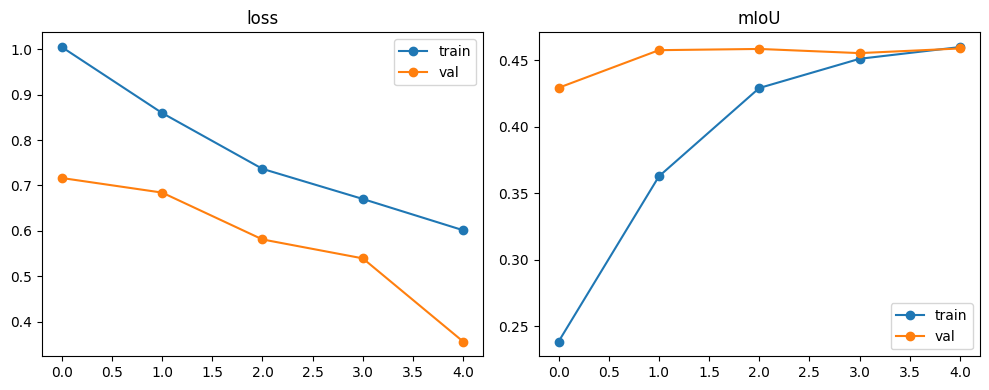

In [12]:
# plot
fig,axes=plt.subplots(1,2,figsize=(10,4))
axes[0].plot(hist["tl"], '-o', label="train")
axes[0].plot(hist["vl"], '-o', label="val")
axes[0].set_title("loss"); axes[0].legend()
axes[1].plot(hist["ti"], '-o', label="train")
axes[1].plot(hist["vi"], '-o', label="val")
axes[1].set_title("mIoU"); axes[1].legend()
plt.tight_layout()

### 6. Prediction Visualization

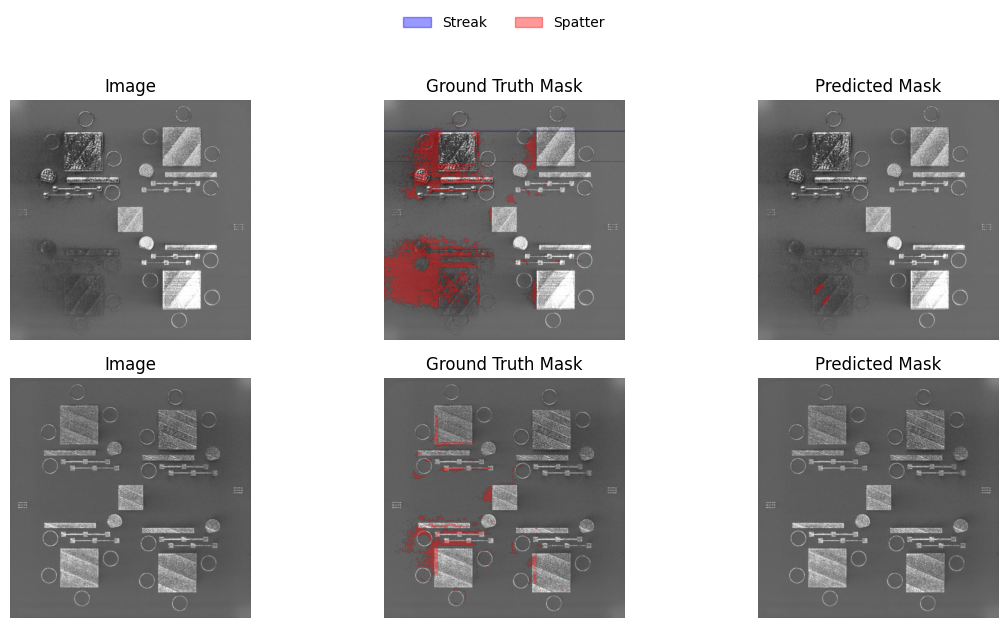

In [24]:
# grab one batch
imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    out   = model(pixel_values=imgs).logits
    out   = F.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = out.argmax(dim=1).cpu().numpy()

batch_sz = imgs.shape[0]
N = min(batch_sz, 4)

fig, axes = plt.subplots(N, 3, figsize=(12, 3 * N))
for i in range(N):
    ax_img, ax_gt, ax_pr = axes[i]

    im = imgs[i].cpu().permute(1,2,0).numpy()
    gt = masks[i].cpu().numpy()
    pr = preds[i]

    # RGBA colormap: 0=transparent, 1=blue, 2=red
    cmap = {
        0: (0,   0,   0,   0.0),
        1: (0,   0,   1,   0.4),
        2: (1,   0,   0,   0.4),
    }

    # build overlays as RGBA images
    overlay_gt = np.zeros((gt.shape[0], gt.shape[1], 4), dtype=float)
    overlay_pr = np.zeros_like(overlay_gt)
    for cls in (1, 2):
        overlay_gt[gt == cls] = cmap[cls]
        overlay_pr[pr == cls] = cmap[cls]

    # 1) raw image
    ax_img.imshow(im)
    ax_img.set_title("Image")
    ax_img.axis("off")

    # 2) ground-truth overlay
    ax_gt.imshow(im)
    ax_gt.imshow(overlay_gt)
    ax_gt.set_title("Ground Truth Mask")
    ax_gt.axis("off")

    # 3) predicted overlay
    ax_pr.imshow(im)
    ax_pr.imshow(overlay_pr)
    ax_pr.set_title("Predicted Mask")
    ax_pr.axis("off")

# legend handles
patch_streak  = mpatches.Patch(color='blue', alpha=0.4, label='Streak')
patch_spatter = mpatches.Patch(color='red',  alpha=0.4, label='Spatter')

# place legend above grid
fig.legend(
    handles=[patch_streak, patch_spatter],
    loc="upper center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.05),
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
